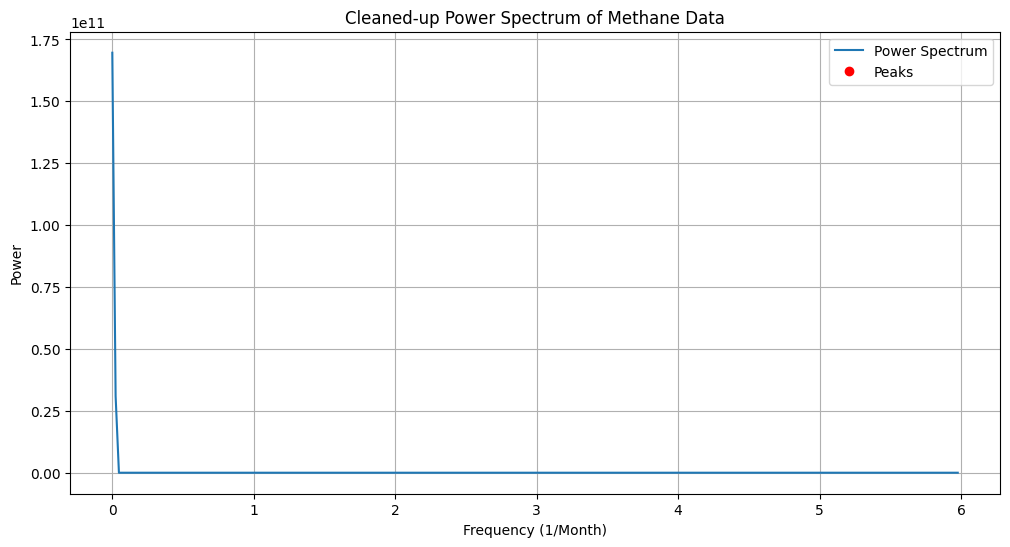

In [ ]:
"""
Methane Data Analysis Module

This module loads, preprocesses, and analyzes methane concentration data over time.
It applies several steps to handle data irregularities, perform spectral analysis, 
and visualize the time series to identify any underlying trends or periodicities.
"""

# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.signal import windows, find_peaks
import pandas as pd
import numpy as np

def get_timeseries(path):
    """
    Reads a JSON file with 'datetime' and 'value' fields and returns
    a pandas Series with datetime as the index and methane concentration as data.

    Parameters:
    - path: str, path to the JSON file.

    Returns:
    - Pandas Series with Datetime index and methane concentration as values.
    """
    # Read JSON file with line-delimited format
    data = pd.read_json(path, lines=True)

    # Convert 'datetime' column to datetime type and set it as the index
    data['datetime'] = pd.to_datetime(data['datetime'])
    data.set_index('datetime', inplace=True)

    # Return the 'value' column as a pandas Series
    return data['value']

# Load the JSON file and extract the time series data
file_path = 'methane-data-collection/data/methane_data.json'
methane_data = get_timeseries(file_path)  # Read the time series

# Handle duplicates by keeping the first occurrence
methane_data = methane_data[~methane_data.index.duplicated(keep='first')]

# Ensure the data is evenly spaced (monthly frequency) and interpolate missing values
methane_data = methane_data.asfreq('MS')  # Monthly frequency
methane_data = methane_data.interpolate(method='time')  # Fill missing data points

# Apply windowing (e.g., Hamming window)
n = len(methane_data)
window = windows.hamming(n)
windowed_data = methane_data * window

# Perform FFT on the windowed data
fft_result = np.fft.fft(windowed_data)

# Zero-padding the FFT result for better frequency resolution
n_padded = 2 ** int(np.ceil(np.log2(len(fft_result))))
padded_fft_result = np.pad(fft_result, (0, n_padded - len(fft_result)), 'constant')

# Calculate frequencies assuming monthly data (1/12 year per sample)
freqs = np.fft.fftfreq(n_padded, d=1/12)

# Remove noise: Simple thresholding based on mean magnitude
magnitude = np.abs(padded_fft_result)
threshold = magnitude.mean() * 1.5
fft_clean = padded_fft_result.copy()
fft_clean[magnitude < threshold] = 0

# Inverse FFT to get cleaned-up time series
cleaned_data = np.fft.ifft(fft_clean)
cleaned_data = np.real(cleaned_data[:n]) / window  # Only keep original data length and correct for windowing

# Calculate power spectrum (squared magnitude of the cleaned FFT)
power_spectrum = np.abs(fft_clean)**2
power_spectrum = power_spectrum[:len(power_spectrum) // 2]  # Use only positive frequencies
freqs = freqs[:len(power_spectrum)]  # Limit frequencies to positive part as well

# Identify peaks in the power spectrum
peaks, _ = find_peaks(power_spectrum, height=power_spectrum.max() * 0.1)

# Plot the cleaned-up power spectrum and highlight peaks
plt.figure(figsize=(12, 6))
plt.plot(freqs, power_spectrum, label='Power Spectrum')
plt.plot(freqs[peaks], power_spectrum[peaks], 'ro', label='Peaks')
plt.title('Cleaned-up Power Spectrum of Methane Data')
plt.xlabel('Frequency (1/Month)')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()
